# Chapter 2
## The factors influencing the occurrence of invasive water hyacinth: An Earth Observation and interpretable machine learning method.

### (1/2) Code to produce all figures and analysis except for local shap explantations. 
### (2/2) refer to "Chapter_2_SHAP_local.ipynb" for local shap explanations.

## Compute shap using Cross Validation similar to that proposed on this medium post

In [3]:
import numpy as np
import pandas as pd
import shap
import fasttreeshap
from tqdm import tqdm
from sklearn.model_selection import GroupKFold, cross_val_predict

# from sklearnex import patch_sklearn
# patch_sklearn()
from sklearn.ensemble import RandomForestClassifier

# from sklearn.metrics import f1_score, classification_report, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt
# import itertools

In [91]:
df = pd.read_csv(r"D:\phd\Chapter_2\nat_drivers\3exports\merged_31082021.csv")

In [92]:
FLC = ['contiguous (indigenous) forest',
 'contiguous low forest & thicket',
 'dense forest & woodland',
 'open woodland',
 'contiguous & dense plantation forest',
 'open & sparse plantation forest',
 'temporary unplanted (clear-felled) plantation forest',
 'low shrubland (other)',
 'low shrubland (fynbos)',
 'low shrubland (succulent karoo)',
 'low shrubland (nama karoo)',
 'sparsely wooded grassland',
 'natural grassland',
 'natural rivers',
 'natural estuaries & lagoons',
 'natural ocean & coastal',
 'natural lakes',
 'natural pans (flooded @ observation times)',
 'artificial dams (including canals)',
 'artificial sewage ponds',
 'artificial flooded mine pits',
 'herbaceous wetlands (currently mapped)',
 'herbaceous wetlands (previously mapped)',
 'mangrove wetlands',
 'natural rock surfaces',
 'dry pans',
 'eroded lands',
 'sand dunes (terrestrial)',
 'coastal sand & dunes',
 'bare riverbed material',
 'other bare',
 'cultivated commercial permanent orchards',
 'cultivated commercial permanent vines',
 'cultivated commercial sugarcane pivot irrigated',
 'cultivated commercial permanent pineapples',
 'cultivated commercial sugarcane non-pivot',
 'cultivated emerging farmer sugarcane non-pivot',
 'commercial annual crops pivot irrigated',
 'commercial annual crops non-pivot irrigated',
 'commercial annual crops rain-fed / dryland',
 'subsistence / small-scale annual crops',
 'fallow land & old fields (trees)',
 'fallow land & old fields (bush)',
 'fallow land & old fields (grass)',
 'fallow land & old fields (bare)',
 'fallow land & old fields (low shrub)',
 'residential formal (tree)',
 'residential formal (bush)',
 'residential formal (low veg / grass)',
 'residential formal (bare)',
 'residential informal (tree)',
 'residential informal (bush)',
 'residential informal (low veg / grass)',
 'residential informal (bare)',
 'village scattered (bare & low veg/ grss combo)',
 'village dense (bare & low veg / grss combo)',
 'smallholdings (tree)',
 'smallholdings (bush)',
 'smallholdings (low veg / grass)',
 'smallholdings (bare)',
 'urban recreational fields (tree)',
 'urban recreational fields (bush)',
 'urban recreational fields (grass)',
 'urban recreational fields (bare)',
 'commercial',
 'industrial',
 'roads & rails (major linear)',
 'mines: surface infrastructure',
 'mines: extraction pits, quarries',
 'mines: salt mines',
 'mine: tailings and resource dumps',
 'land-fills',
 'fallow land & old fields (wetlands)']

In [93]:
irrelevant = ['Unnamed: 0', 'system:index','ORIG_FID','gridcode', 'nx','ny','.geo','matches','moss-coverfraction']
redundant = ['bedrock_depth', 'carbon_organic', 'carbon_total', 'bulk_density', 'distance_to_coast', 'ph', 'warea', 'texture_class', 'silt_content']

df = df.dropna(subset=['pxid'])
df = df.drop([*irrelevant, *redundant], axis=1)

rep0 = ['flood','wSeasonality', 'aq_veg_area', 'rwi']
df[rep0+FLC] = df[rep0+FLC].fillna(0)
df = df.dropna()

In [94]:
# 82 features
top_fts = ['CHILI', 'Global_Human_Modification', 'SPI', 'bare-coverfraction',
       'cation_ex_capacity', 'clay_content', 'commercial',
       'commercial annual crops rain-fed / dryland',
       'contiguous & dense plantation forest',
       'contiguous (indigenous) forest', 'crops-coverfraction',
       'cultivated commercial permanent pineapples',
       'cultivated commercial sugarcane non-pivot', 'dense forest & woodland',
       'distance_to_roads', 'dsrcnt', 'fcc', 'flood', 'grass-coverfraction',
       'herbaceous wetlands (previously mapped)', 'industrial',
       'low shrubland (fynbos)', 'low shrubland (nama karoo)',
       'mangrove wetlands', 'minT', 'mines: surface infrastructure',
       'natural rock surfaces', 'nitrogen_total',
       'open & sparse plantation forest', 'precipitation',
       'roads & rails (major linear)', 'runoff', 'sand_content',
       'shrub-coverfraction', 'soc_100-200cm_mean',
       'sparsely wooded grassland', 'stone_content',
       'subsistence / small-scale annual crops',
       'temporary unplanted (clear-felled) plantation forest', 'topD',
       'tree-coverfraction', 'urban-coverfraction', 'wSeasonality',
       'water-permanent-coverfraction', 'water-seasonal-coverfraction',
       'wind_speed', 'contiguous low forest & thicket',
       'cultivated commercial permanent orchards',
       'cultivated commercial permanent vines',
       'low shrubland (succulent karoo)', 'natural estuaries & lagoons',
       'natural grassland', 'natural rivers', 'land-fills',
       'mine: tailings and resource dumps', 'mines: extraction pits, quarries',
       'mines: salt mines', 'natural lakes', 'natural ocean & coastal',
       'natural pans (flooded @ observation times)',
       'commercial annual crops pivot irrigated',
       'cultivated emerging farmer sugarcane non-pivot',
       'fallow land & old fields (bush)', 'fallow land & old fields (trees)',
       'residential formal (bare)', 'residential formal (bush)',
       'residential formal (low veg / grass)', 'residential informal (tree)',
       'urban recreational fields (bush)', 'urban recreational fields (tree)',
       'village scattered (bare & low veg/ grss combo)', 'aq_veg_area',
       'smallholdings (low veg / grass)', 'residential informal (bush)',
       'open woodland', 'cultivated commercial sugarcane pivot irrigated',
       'coastal sand & dunes', 'sand dunes (terrestrial)',
       'artificial dams (including canals)', 'artificial flooded mine pits',
       'artificial sewage ponds', 'low shrubland (other)']

In [95]:
df = df[[*top_fts, 'label', 'pxid']]

In [96]:
df.reset_index(inplace=True, drop=True)

In [97]:
df.shape

(211086, 84)

In [12]:
X = df[top_fts]
y = df[['label']]
columns = list(X)

In [13]:
params = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 542, 'bootstrap': False}

clf = RandomForestClassifier(**params, random_state=123, n_jobs = -1)

In [11]:
# # udfs ----
import seaborn as sns
import matplotlib.pyplot as plt

# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    plt.figure(figsize = (20,20))
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)
# var_imp_plot(perm_imp_rfpimp.reset_index(), 'Permutation feature importance (rfpimp)')

In [26]:
base_imp = imp_df(X.columns, clf.feature_importances_)
base_imp

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

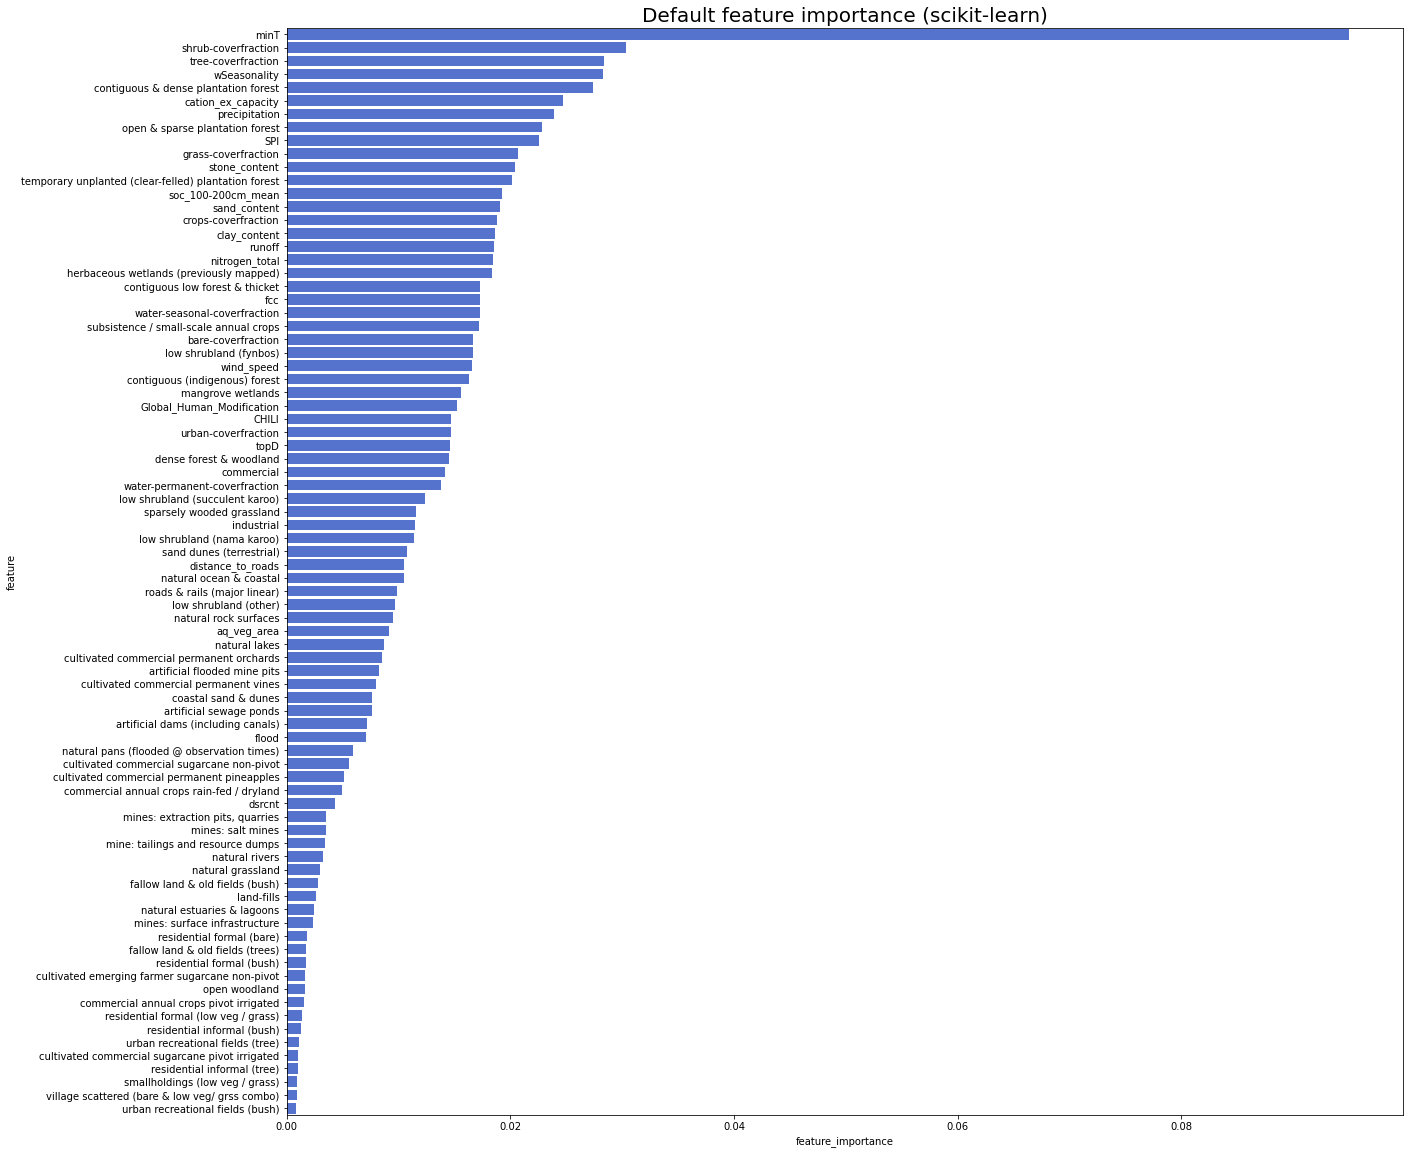

In [68]:
var_imp_plot(base_imp, 'Default feature importance (scikit-learn)')

# Compute shap

In [12]:
# blocks = df['pxid'].values
# group_kfold = GroupKFold(n_splits=10)
# Generator for the train/test indices
# block_kfold = group_kfold.split(X, y, blocks)  
# Create a nested list of train and test indices for each fold
# train_indices, test_indices = [list(traintest) for traintest in zip(*block_kfold)]
# block_cv = [*zip(train_indices,test_indices)]
# predictions = cross_val_predict(model, X, y, cv=block_cv)

In [14]:
#This cell takes a while in the order of 10 mins on a 8th gen i7
#loading and preparing the data
X = df[top_fts]
y = df[['label']]
columns = list(X)

groups = df['pxid'].values
group_kfold = GroupKFold(n_splits=10)
# group_kfold.get_n_splits(X, y, groups)

list_shap_values = list()
list_test_sets = list()
# list_shap_interaction =list()

for train_index, test_index in tqdm(group_kfold.split(X, y, groups=groups), total=group_kfold.get_n_splits(), desc="group k-fold"):
    print('Splitting train-test data')
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = pd.DataFrame(X_train,columns=columns)
    X_test = pd.DataFrame(X_test,columns=columns)

    #training model
    print('Fitting model')
    clf.fit(X_train, y_train.values.ravel())

    #explaining model
    print('Computing Shap values')
    np.seterr(invalid= 'ignore')
    explainer = fasttreeshap.TreeExplainer(clf, method= 'v2', n_jobs=-1, approximate=True)
    shap_values = explainer(X_test.head(X_test.shape[0])).values#.shap_values(X_test.head())
#     shap_interaction_values = explainer.shap_interaction_values(X_test)
    #for each iteration we save the test_set index and the shap_values
    list_shap_values.append(shap_values)
#     list_shap_interaction.append(shap_interaction_values)
    list_test_sets.append(test_index)

group k-fold:   0%|                                                                             | 0/10 [00:00<?, ?it/s]

Splitting train-test data
Fitting model
Computing Shap values


group k-fold:  10%|██████▊                                                             | 1/10 [04:26<39:55, 266.12s/it]

Splitting train-test data
Fitting model
Computing Shap values


group k-fold:  20%|█████████████▌                                                      | 2/10 [08:42<34:45, 260.64s/it]

Splitting train-test data
Fitting model
Computing Shap values


group k-fold:  30%|████████████████████▍                                               | 3/10 [12:59<30:12, 258.94s/it]

Splitting train-test data
Fitting model
Computing Shap values


group k-fold:  40%|███████████████████████████▏                                        | 4/10 [17:15<25:44, 257.49s/it]

Splitting train-test data
Fitting model
Computing Shap values


group k-fold:  50%|██████████████████████████████████                                  | 5/10 [21:26<21:15, 255.19s/it]

Splitting train-test data
Fitting model
Computing Shap values


group k-fold:  60%|████████████████████████████████████████▊                           | 6/10 [25:39<16:58, 254.59s/it]

Splitting train-test data
Fitting model
Computing Shap values


group k-fold:  70%|███████████████████████████████████████████████▌                    | 7/10 [29:43<12:32, 250.98s/it]

Splitting train-test data
Fitting model
Computing Shap values


group k-fold:  80%|██████████████████████████████████████████████████████▍             | 8/10 [33:46<08:17, 248.69s/it]

Splitting train-test data
Fitting model
Computing Shap values


group k-fold:  90%|█████████████████████████████████████████████████████████████▏      | 9/10 [37:51<04:07, 247.28s/it]

Splitting train-test data
Fitting model
Computing Shap values


group k-fold: 100%|███████████████████████████████████████████████████████████████████| 10/10 [41:51<00:00, 251.14s/it]


In [14]:
def xgb_shap_transform_scale(original_shap_values, Y_pred, which):
    from scipy.special import expit
    
    #Compute the transformed base value, which consists in applying the logit function to the base value
    from scipy.special import expit #Importing the logit function for the base value transformation
    untransformed_base_value = original_shap_values.base_values[-1]
   
    #Computing the original_explanation_distance to construct the distance_coefficient later on
    original_explanation_distance = np.sum(original_shap_values.values, axis=1)[which]
    
    base_value = expit(untransformed_base_value ) # = 1 / (1+ np.exp(-untransformed_base_value))

    #Computing the distance between the model_prediction and the transformed base_value
    distance_to_explain = Y_pred[which] - base_value

    #The distance_coefficient is the ratio between both distances which will be used later on
    distance_coefficient = original_explanation_distance / distance_to_explain

    #Transforming the original shapley values to the new scale
    shap_values_transformed = original_shap_values / distance_coefficient

    #Finally resetting the base_value as it does not need to be transformed
    shap_values_transformed.base_values = base_value
    shap_values_transformed.data = original_shap_values.data
    
    #Now returning the transformed array
    return shap_values_transformed

In [15]:
#combining results from all iterations
test_set = list_test_sets[0]
shap_values = np.array(list_shap_values[0])
# interaction_values = list_shap_interaction[0]

for i in range(1,len(list_test_sets)):
    test_set = np.concatenate((test_set,list_test_sets[i]),axis=0)
    shap_values = np.concatenate((shap_values,np.array(list_shap_values[i])),axis=0)
#     interaction_values = np.concatenate((interaction_values,list_shap_interaction[i]),axis=0)
    
#bringing back variable names
X_test = pd.DataFrame(X.iloc[test_set],columns=columns)

In [16]:
shap_values.shape

(211086, 82, 2)

In [98]:
feature_names = ['Microclimate - Continous Heat Insolation Index (CHILI)', 'Global human modification', 'Stream power index', 'Bare-coverfraction',
       'Cation exchange capacity', 'Clay content', 'Commercial',
       'Commercial annual crops rain-fed / dryland',
       'Contiguous & dense plantation forest',
       'Contiguous (indigenous) forest', 'Crops-coverfraction',
       'Cultivated commercial permanent pineapples',
       'Cultivated commercial sugarcane non-pivot', 'Dense forest & woodland',
       'Distance_to_roads', 'Connectivity - Number of downstream rivers',
        'Fertility Capability Classification', 'Flood risk', 'Grass-coverfraction',
       'Herbaceous wetlands (previously mapped)', 'Industrial',
       'Low shrubland (fynbos)', 'Low shrubland (nama karoo)',
       'Mangrove wetlands', 'Minimum Temperature in the coldest month (1970-1990)', 'Mines: surface infrastructure',
       'Natural rock surfaces', 'Total riparian nitrogen',
       'Open & sparse plantation forest', 'Precipitation',
       'Roads & rails (major linear)', 'Runoff', 'Riparian soil content',
       'Shrub-coverfraction', 'Soil organic carbon (100-200cm)',
       'Sparsely wooded grassland', 'Stone_content',
       'Subsistence / small-scale annual crops',
       'Temporary unplanted (clear-felled) plantation forest', 'Microclimate - topographic diversity',
       'Tree-coverfraction', 'Urban-coverfraction', 'Surface water persistence',
       'Water-permanent-coverfraction', 'Water-seasonal-coverfraction',
       'Wind speed', 'Contiguous low forest & thicket',
       'Cultivated commercial permanent orchards',
       'Cultivated commercial permanent vines',
       'Low shrubland (succulent karoo)', 'Natural estuaries & lagoons',
       'Natural grassland', 'Natural rivers', 'Land-fills',
       'Mine: tailings and resource dumps', 'Mines: extraction pits, quarries',
       'Mines: salt mines', 'Natural lakes', 'Natural ocean & coastal',
       'Natural pans (flooded at observation times)',
       'Commercial annual crops pivot irrigated',
       'Cultivated emerging farmer sugarcane non-pivot',
       'Fallow land & old fields (bush)', 'Fallow land & old fields (trees)',
       'Residential formal (bare)', 'Residential formal (bush)',
       'Residential formal (low veg / grass)', 'Residential informal (tree)',
       'Urban recreational fields (bush)', 'Urban recreational fields (tree)',
       'Village scattered (bare & low veg/ grss combo)', 'Interspecies competition - area of aquatic vegetation',
       'Smallholdings (low veg / grass)', 'Residential informal (bush)',
       'Open woodland', 'Cultivated commercial sugarcane pivot irrigated',
       'Coastal sand & dunes', 'Sand dunes (terrestrial)',
       'Artificial dams (including canals)', 'Artificial flooded mine pits',
       'Artificial sewage ponds', 'Low shrubland (other)']

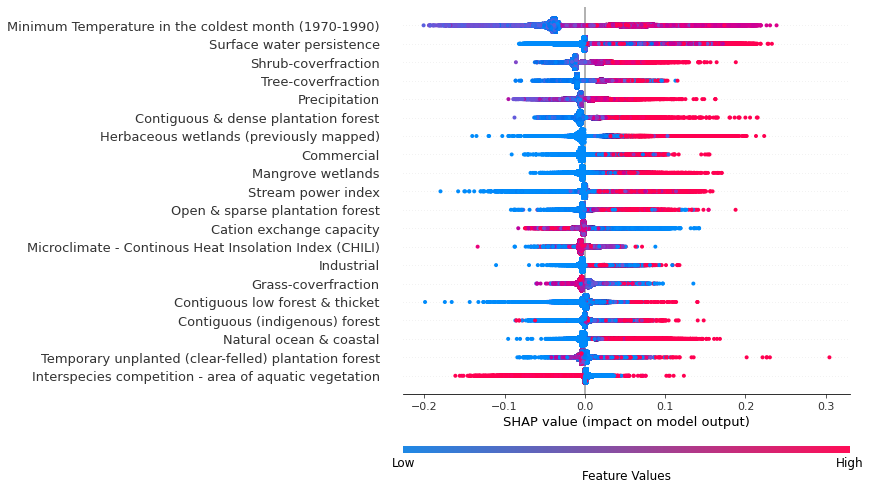

In [24]:
#creating explanation plot for the whole experiment, the last dimension from shap_values indicate the class we are predicting (0=0, 1=1)
# ,plot_type= 'bar'
import matplotlib.pyplot as plt
fasttreeshap.summary_plot(shap_values[:,:,1], X_test, feature_names = feature_names, max_display = 20, show=False, color_bar=False)

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# "#1E88E5", "#ff0d57", "#13B755", "#7C52FF", "#FFC000", "#00AEEF"
colors = ["#1E88E5", "#ff0d57"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

m = plt.cm.ScalarMappable(cmap = cmap)
m.set_clim(0., 1.)
cb = plt.colorbar(m,orientation = 'horizontal', label= 'Feature values', ticks=[0, 1], format= '%.0f', aspect= 60, pad=0.10 )
cb.set_ticklabels(['Low', 'High'])
cb.set_label('Feature Values',size=12, labelpad=0)
cb.ax.tick_params(labelsize=12, length=0)
cb.set_alpha(1)
cb.outline.set_visible(False)

plt.savefig(r'D:\phd\Chapter_2\nat_drivers\4results\figures3\vars20_beeswarm.png', dpi = 500, transparent=True, bbox_inches='tight')

In [29]:
# colours = ['grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey',
#           'grey','grey','grey','grey','grey','grey','grey','grey','grey','grey',
#           'green','orange','orange','orange','orange','grey', 'orange', 'green', 'orange','green',
#           'grey', 'grey', 'grey','orange', 'orange', 'orange', 'orange', 'orange', 'orange','orange',
#            'orange', 'orange', 'grey', 'grey','orange', 'orange', 'green', 'grey', 'orange','grey',
#            'orange', 'green', 'green', 'orange', 'orange', 'orange', 'orange', 'grey', 'grey','orange',
#            'orange','green', 'green', 'green', 'orange', 'orange', 'orange', 'orange', 'green', 'green',
#            'green','orange','orange','orange','orange','orange','orange','orange','orange','orange',
#            'orange','orange']

colours = ['green', 'green', 'orange', 'orange', 'orange', 'orange', 'green', 'green',
           'green','orange','orange','orange','orange','orange','orange','orange','orange','orange',
           'orange','orange']


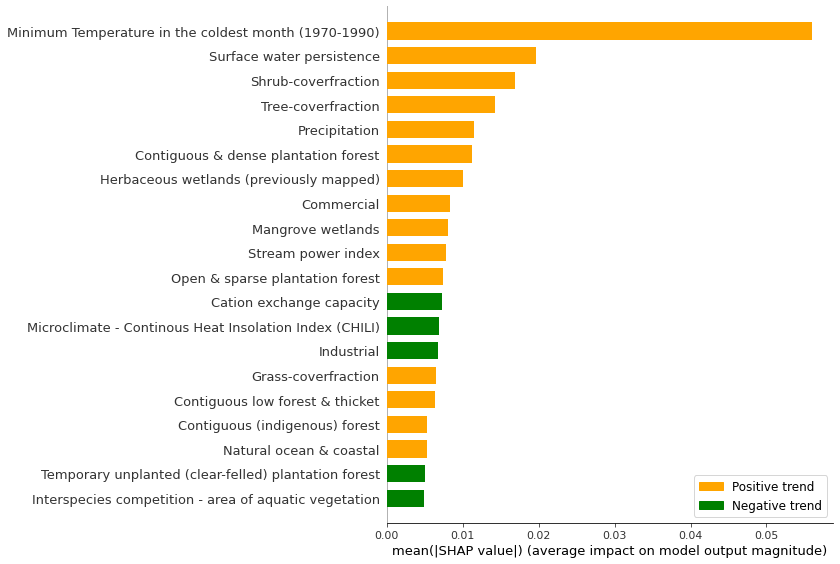

In [31]:
#creating explanation plot for the whole experiment, the first dimension from shap_values indicate the class we are predicting (0=0, 1=1)
# Positive = orange
# neutral = grey
# negative = green

shap.summary_plot(shap_values[:,:,1], X_test, feature_names = feature_names, color = colours,max_display = 20, show=False,plot_type= 'bar')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

o_patch = mpatches.Patch(color='orange', label='Positive trend')
# g_patch = mpatches.Patch(color='grey', label= 'Variable (inconclusive) effect')
gr_patch = mpatches.Patch(color='green', label='Negative trend')
plt.legend(handles=[o_patch, gr_patch], loc = 'best', fontsize = 12)

# plt.show()
plt.savefig(r'D:\phd\Chapter_2\nat_drivers\4results\figures3\vars20_beeswarm_bar.png', dpi = 500, transparent=True, bbox_inches='tight')

# Dependence plots

In [24]:
dependency_feature_names = ['Microclimate - Continous Heat Insolation Index (CHILI)',
       'Global human modification', 'Stream power index', 'Bare-coverfraction',
       'Cation exchange capacity', 'Clay content', 'Commercial',
       'Commercial annual crops rain-fed / dryland',
       'Contiguous & dense plantation forest',
       'Contiguous (indigenous) forest', 'Crops-coverfraction',
       'Cultivated commercial permanent pineapples',
       'Cultivated commercial sugarcane non-pivot', 'Dense forest & woodland',
       'Distance_to_roads', 'Connectivity - Number of downstream rivers',
       'Fertility Capability Classification', 'Flood risk (m)',
       'Grass-coverfraction (%)', 'Herbaceous wetlands (previously mapped)',
       'Industrial (km^2)', 'Low shrubland (fynbos)', 'Low shrubland (nama karoo)',
       'Mangrove wetlands',
       'Minimum Temperature in the coldest month (°C)',
       'Mines: surface infrastructure', 'Natural rock surfaces',
       'Total riparian nitrogen (g\kg)', 'Open & sparse plantation forest',
       'Precipitation (mm)', 'Roads & rails (km^2)', 'Runoff',
       'Riparian soil content', 'Shrub-coverfraction (%)',
       'Soil organic carbon (100-200cm)', 'Sparsely wooded grassland',
       'Stone_content', 'Subsistence / small-scale annual crops',
       'Temporary unplanted (clear-felled) plantation forest',
       'Microclimate - topographic diversity', 'Tree-coverfraction (%)',
       'Urban-coverfraction', 'Surface water persistence (months present)',
       'Water-permanent-coverfraction', 'Water-seasonal-coverfraction',
       'Wind speed', 'Contiguous low forest & thicket',
       'Cultivated commercial permanent orchards',
       'Cultivated commercial permanent vines',
       'Low shrubland (succulent karoo)', 'Natural estuaries & lagoons',
       'Natural grassland', 'Natural rivers', 'Land-fills',
       'Mine: tailings and resource dumps', 'Mines: extraction pits, quarries',
       'Mines: salt mines', 'Natural lakes', 'Natural ocean & coastal',
       'Natural pans (flooded at observation times)',
       'Commercial annual crops pivot irrigated',
       'Cultivated emerging farmer sugarcane non-pivot',
       'Fallow land & old fields (bush)', 'Fallow land & old fields (trees)',
       'Residential formal (bare)', 'Residential formal (bush)',
       'Residential formal (low veg / grass)', 'Residential informal (tree)',
       'Urban recreational fields (bush)', 'Urban recreational fields (tree)',
       'Village scattered (bare & low veg/ grss combo)',
       'Interspecies competition - area of aquatic vegetation (m^2)',
       'Smallholdings (low veg / grass)', 'Residential informal (bush)',
       'Open woodland', 'Cultivated commercial sugarcane pivot irrigated',
       'Coastal sand & dunes', 'Sand dunes (terrestrial)',
       'Artificial dams (including canals)', 'Artificial flooded mine pits',
       'Artificial sewage ponds', 'Low shrubland (other)']

In [25]:
X_test.columns = dependency_feature_names
# X_test.columns

In [26]:
vars = ['Microclimate - Continous Heat Insolation Index (CHILI)','Microclimate - topographic diversity',
       'Flood risk (m)', 'Total riparian nitrogen (g\kg)', 'Precipitation (mm)', 'Global human modification',
       'Interspecies competition - area of aquatic vegetation (m^2)']

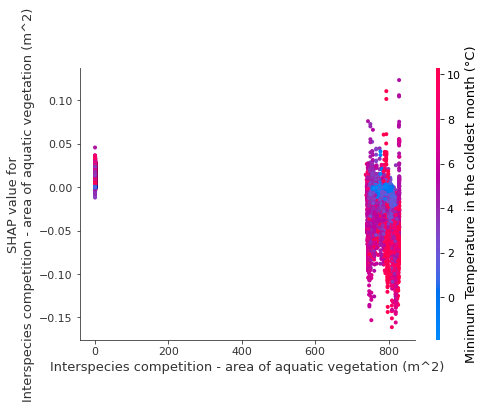

In [47]:
# var = 'Minimum Temperature in the coldest month (°C)'
# var = 'Surface water persistence (months present)'
var = 'Interspecies competition - area of aquatic vegetation (m^2)'

shap.dependence_plot(var ,shap_values[1], X_test, show=False)

plt.savefig(f"D:/phd/Chapter_2/nat_drivers/4results/figures2/{str(var)}.png", dpi = 500, transparent=True, bbox_inches='tight')

# plt.ylabel("Specific Storage Values ($km^{2}$)", fontsize = 12 )

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='wSeasonality', ylabel='shap_wSeasonality'>

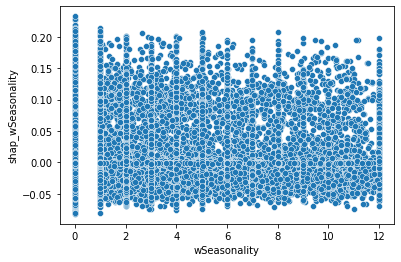

In [80]:
import seaborn as sns
sns.scatterplot(df['wSeasonality'], (df['shap_' + 'wSeasonality']))

In [64]:
df.columns.tolist()

['CHILI',
 'Global_Human_Modification',
 'SPI',
 'bare-coverfraction',
 'cation_ex_capacity',
 'clay_content',
 'commercial',
 'commercial annual crops rain-fed / dryland',
 'contiguous & dense plantation forest',
 'contiguous (indigenous) forest',
 'crops-coverfraction',
 'cultivated commercial permanent pineapples',
 'cultivated commercial sugarcane non-pivot',
 'dense forest & woodland',
 'distance_to_roads',
 'dsrcnt',
 'fcc',
 'flood',
 'grass-coverfraction',
 'herbaceous wetlands (previously mapped)',
 'industrial',
 'low shrubland (fynbos)',
 'low shrubland (nama karoo)',
 'mangrove wetlands',
 'minT',
 'mines: surface infrastructure',
 'natural rock surfaces',
 'nitrogen_total',
 'open & sparse plantation forest',
 'precipitation',
 'roads & rails (major linear)',
 'runoff',
 'sand_content',
 'shrub-coverfraction',
 'soc_100-200cm_mean',
 'sparsely wooded grassland',
 'stone_content',
 'subsistence / small-scale annual crops',
 'temporary unplanted (clear-felled) plantation for

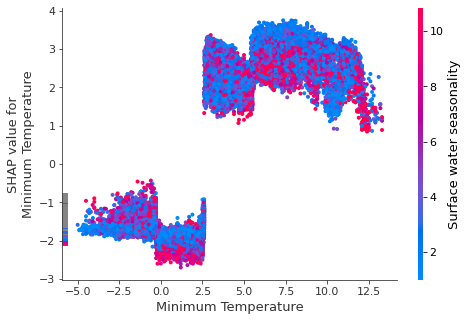

In [78]:
shap.dependence_plot(5,shap_values[1], X_test, interaction_index=2)

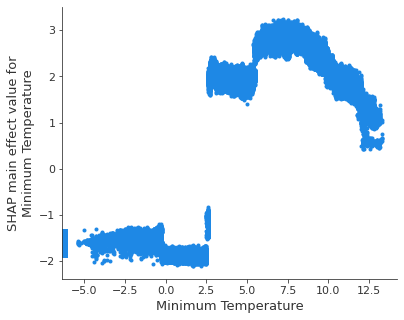

In [71]:
shap.dependence_plot((5,5),interaction_values, X_test)

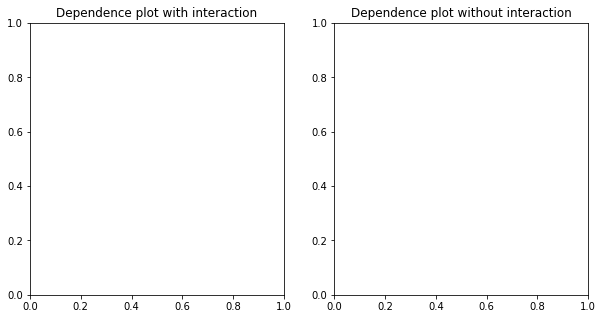

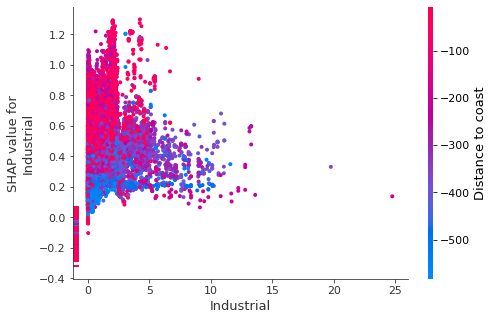

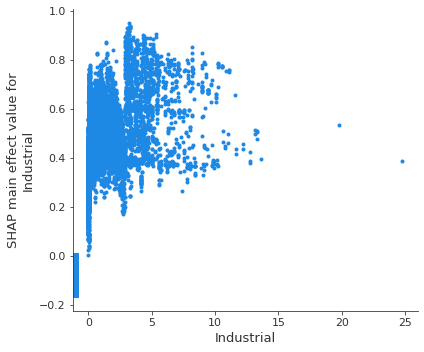

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


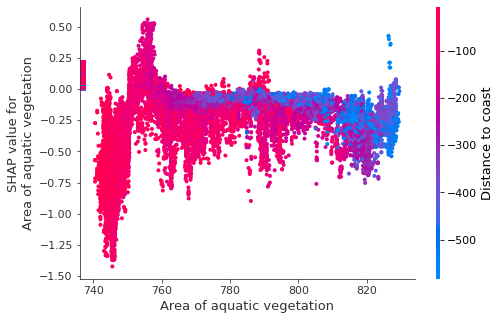

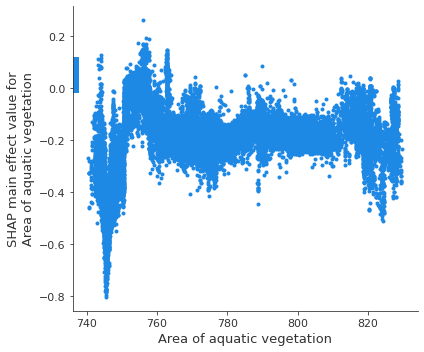

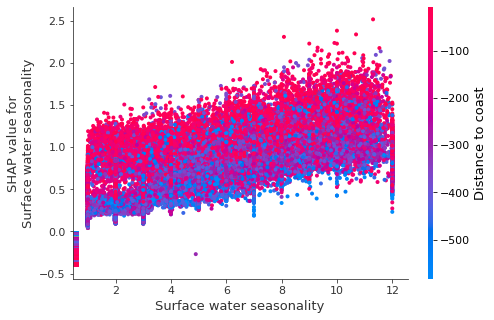

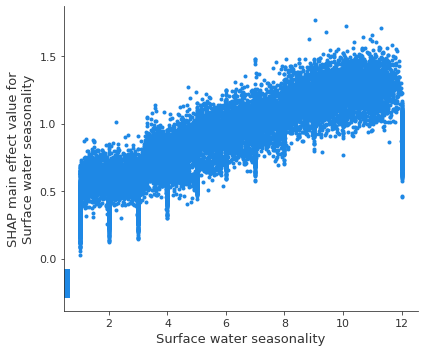

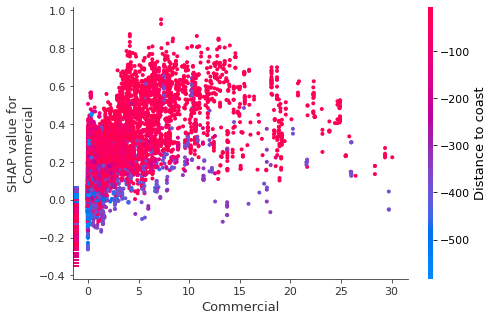

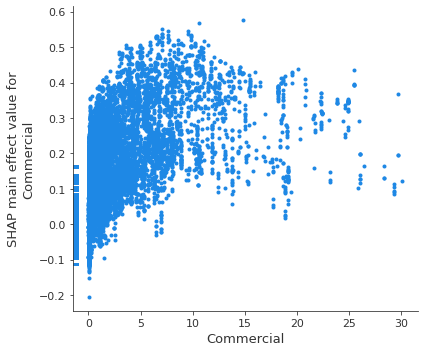

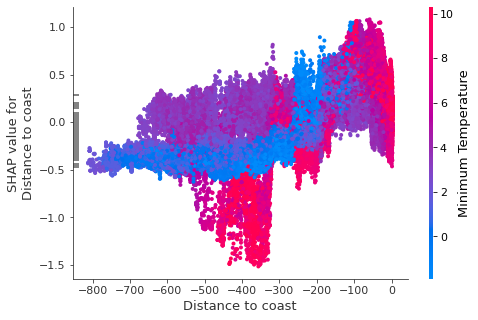

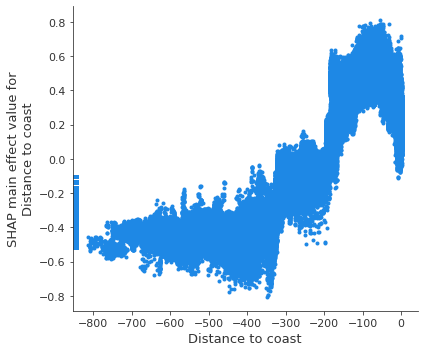

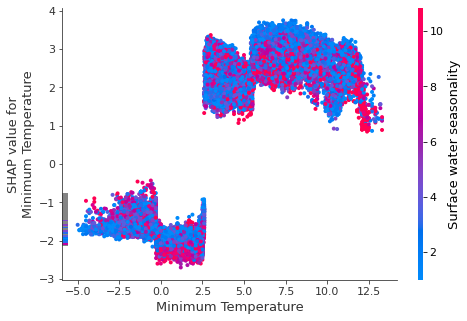

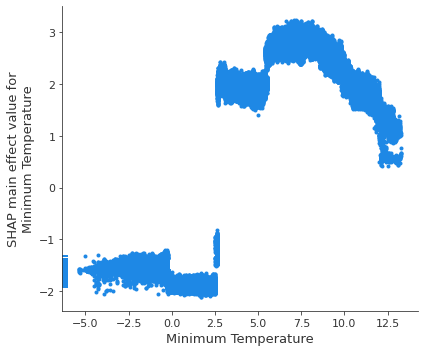

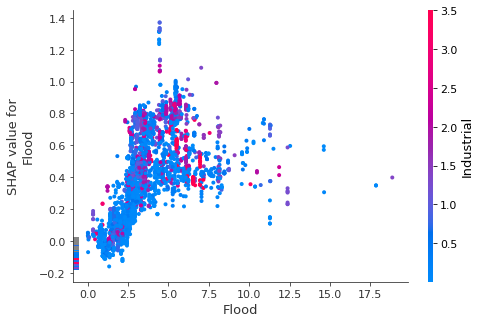

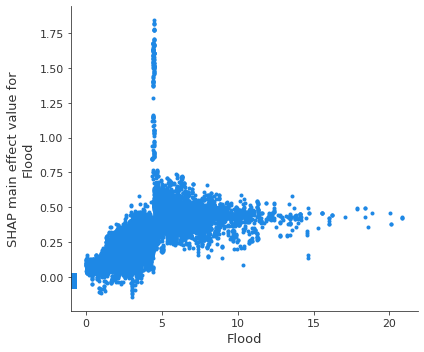

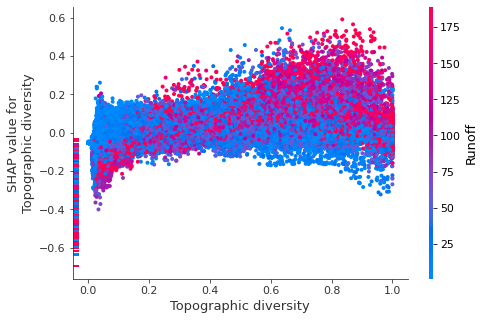

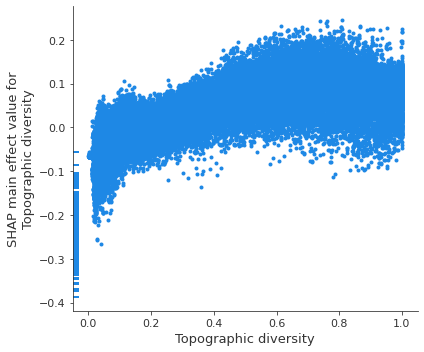

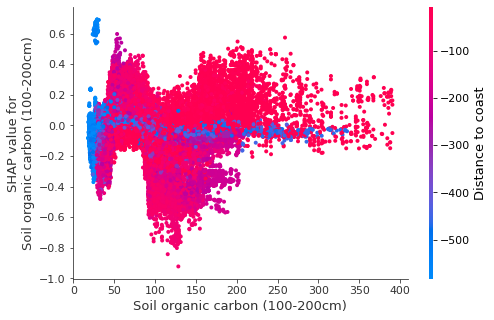

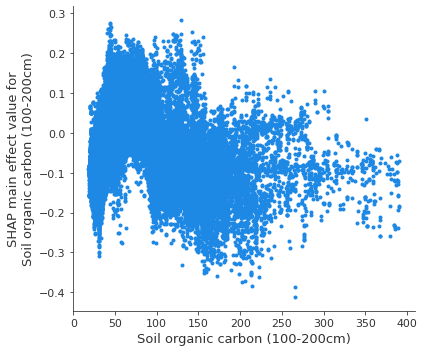

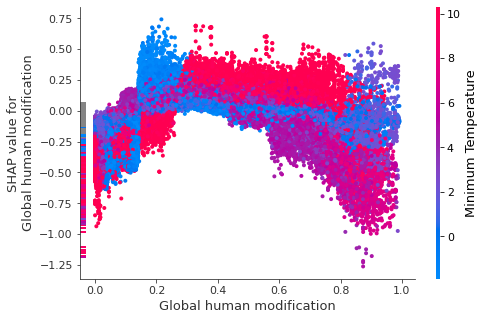

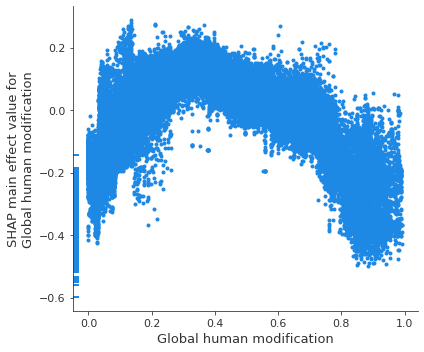

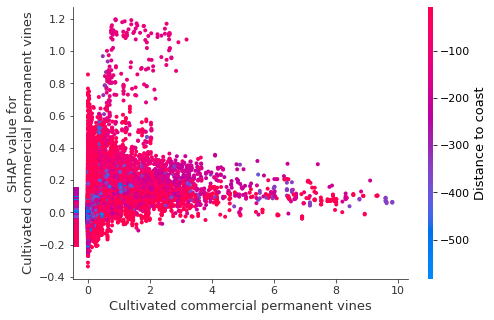

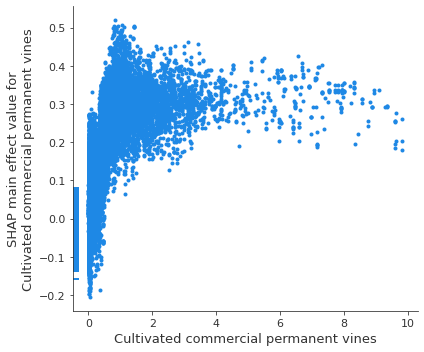

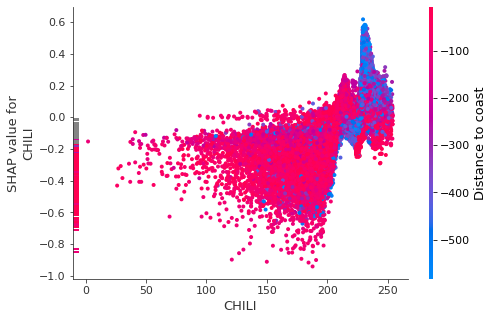

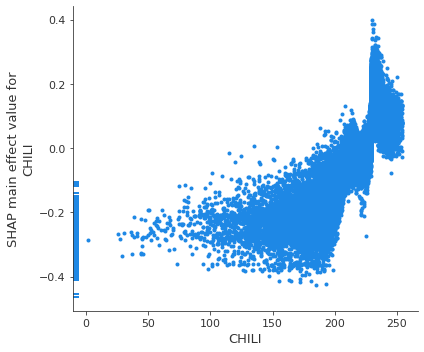

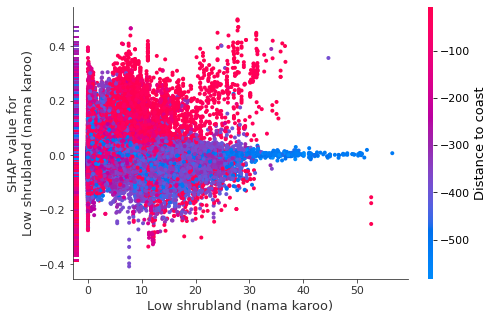

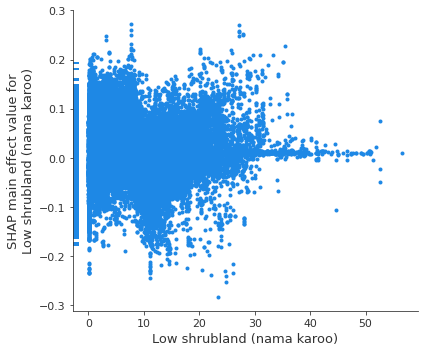

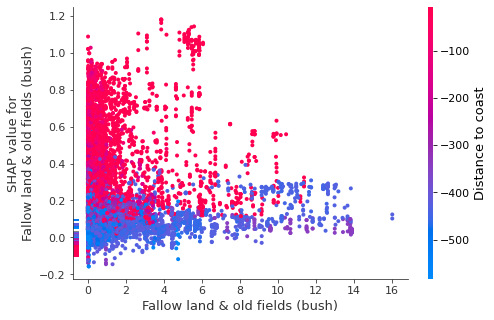

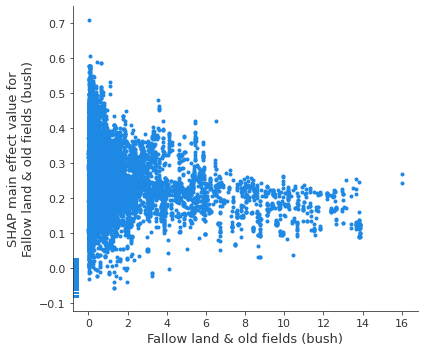

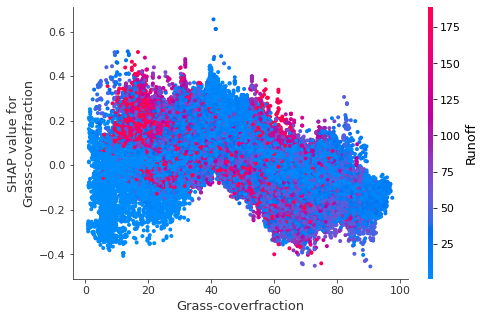

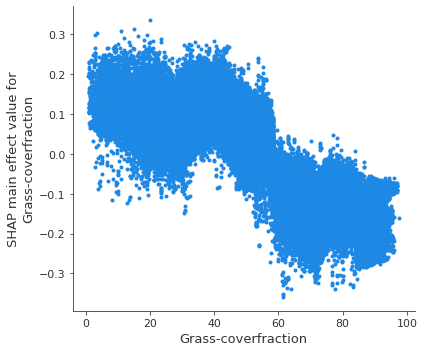

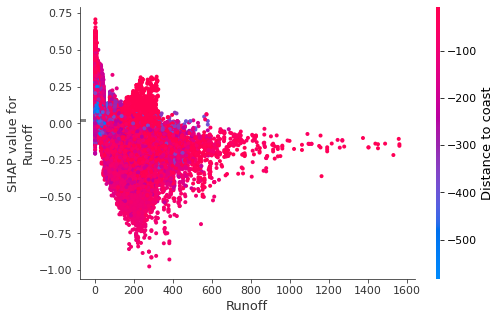

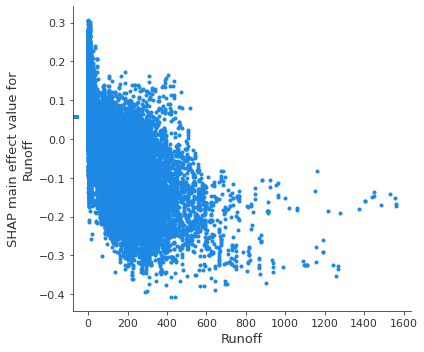

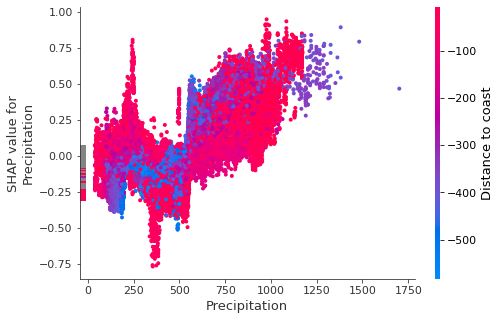

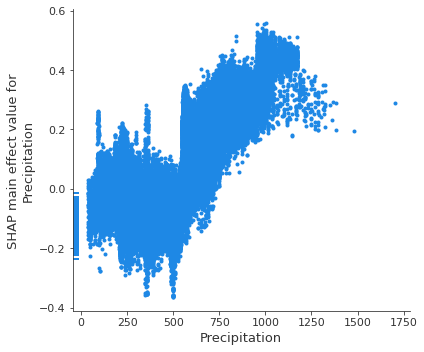

In [76]:
fig = plt.figure(figsize=(10,5))

for i in range(len(X_test.columns)):
    ax1 = fig.add_subplot(121)
    shap.dependence_plot(i, shap_values[1], X_test, show = False)
    ax1.title.set_text('Dependence plot with interaction')
    plt.savefig(r'D:\phd\Chapter_3\nat_drivers\4results\figures\int_'+ str(feature_names[i]) + '.png', dpi = 500, transparent=True, bbox_inches='tight')

    ax2 = fig.add_subplot(122)
    shap.dependence_plot((i, i), interaction_values, X_test, show = False)
    ax2.title.set_text('Dependence plot without interaction')
    plt.tight_layout()
    plt.savefig(r'D:\phd\Chapter_3\nat_drivers\4results\figures\noint_'+ str(feature_names[i]) + '.png', dpi = 500, transparent=True, bbox_inches='tight')
    plt.show()

In [34]:
shap_values.shape

(211086, 82, 2)

In [35]:
df.shape

(211086, 84)

## Spatial distribution of variable importance

In [36]:
#add shap columns to df
for i in tqdm(range(0, len(list(X_test)))):
    ft_name =  str(list(X_test)[i])
    df= df.loc[test_set]
    df['shap_' + ft_name]= shap_values[:, i, 1]   

100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [00:22<00:00,  3.63it/s]


In [23]:
df.to_csv(r"D:\phd\Chapter_2\nat_drivers\3exports\complete_wshap_01102021.csv")

## shap summary plot by province

In [40]:
# Link to shapefile
import ee
import geemap
import geopandas as gpd
from geopandas.tools import sjoin
import matplotlib.pyplot as plt
import shap
from matplotlib.colors import LinearSegmentedColormap
ee.Initialize()

# # Grid
# eegrid = ee.FeatureCollection('users/geethensingh/SA_Grid_1dgr')
# grid = geemap.ee_to_geopandas(eegrid, selectors=['fid']).set_crs('EPSG:4326').to_crs(epsg = '4326').to_crs(epsg = '3857')

# Provinces
provinces = gpd.read_file(r"D:\Miscellenous\Data\SA_boundaries\zaf_admbnda_adm1_sadb_ocha_20201109.shp", crs=4326)
provinces= provinces.to_crs(3857)
# provinces = provinces[provinces.NAME_1!= 'Western Cape (isolated islands)']

In [41]:
countries = ee.FeatureCollection("USDOS/LSIB/2017")
geometry = ee.Geometry.Point([27.7,-25.5])
SA = countries.filterBounds(geometry).geometry()

# grid for aggregating shap
# Generate a random image of integers in Albers projection at the specified cell size.
seed = 123
cellSize = 5000

proj = ee.Projection("EPSG:3857").atScale(cellSize)
eegrid = ee.Image.random(seed).multiply(1e6).int().reproject(proj).rename('pxid')
eegrid = eegrid.addBands(eegrid).reduceToVectors(**{'reducer': ee.Reducer.first(),'geometry': SA, 'scale':5000})
# print(eegrid.first().getInfo())

In [42]:
def largefc_to_geopandas(featurecollection, step_size = 5000):
    """
    function to convert a featurecollection with more than 5000 elements to a pandas dataframe
    
    featurecollection: earth engine feature collection with more than 5000 elements
    step_size: Th enumber of elemenst to process at once. Must be less than equal to 5000
    
    """
    gdf = gpd.GeoDataFrame()
    fclist = featurecollection.toList(featurecollection.size())
    fcsize = featurecollection.size().getInfo()
    for i in tqdm(range(0,fcsize,step_size)):
        fc = ee.FeatureCollection(fclist.slice(i,i+step_size))
        gdf = gdf.append(geemap.ee_to_geopandas(fc, selectors=['pxid']))
    return gdf

grid = largefc_to_geopandas(eegrid).set_crs('EPSG:4326').to_crs("EPSG:3857")

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:41<00:00,  3.19s/it]


In [ ]:
provinces.to_file(r"D:\phd\Chapter_2\nat_drivers\3exports\provinces.shp")
grid.to_file(r"D:\phd\Chapter_2\nat_drivers\3exports\grid5km.shp")

In [43]:
# Read identity layer (created in ArcMap)
prov_fid = gpd.read_file(r"D:\phd\Chapter_2\nat_drivers\3exports\provs_grid_identity2.shp")

In [44]:
prov_fid.rename(columns = {'label':'pxid'}, inplace = True)
prov_fid = prov_fid[['pxid','NAME_1']]
prov_fid.columns

Index(['pxid', 'NAME_1'], dtype='object')

In [45]:
merge = pd.merge(df, prov_fid, on=["pxid"], how='outer')
merge.dropna(inplace=True)
merge.shape

(233095, 167)

In [46]:
merge.NAME_1.unique()

array(['Limpopo', 'Mpumalanga', 'Northern Cape', 'Eastern Cape',
       'Western Cape', 'North West', 'Gauteng', 'KwaZulu-Natal',
       'Free State'], dtype=object)

In [47]:
shap_df = merge.loc[:, merge.columns.str.startswith('shap')]
shap_df.columns
test = merge.loc[:,~merge.columns.str.startswith(('shap', 'label', 'pxid', 'NAME_1'))]
test.columns = feature_names
test.columns

Index(['Microclimate - Continous Heat Insolation Index (CHILI)',
       'Global human modification', 'Stream power index', 'Bare-coverfraction',
       'Cation exchange capacity', 'Clay content', 'Commercial',
       'Commercial annual crops rain-fed / dryland',
       'Contiguous & dense plantation forest',
       'Contiguous (indigenous) forest', 'Crops-coverfraction',
       'Cultivated commercial permanent pineapples',
       'Cultivated commercial sugarcane non-pivot', 'Dense forest & woodland',
       'Distance_to_roads', 'Connectivity - Number of downstream rivers',
       'Fertility Capability Classification', 'Flood risk',
       'Grass-coverfraction', 'Herbaceous wetlands (previously mapped)',
       'Industrial', 'Low shrubland (fynbos)', 'Low shrubland (nama karoo)',
       'Mangrove wetlands',
       'Minimum Temperature in the coldest month (1970-1990)',
       'Mines: surface infrastructure', 'Natural rock surfaces',
       'Total riparian nitrogen', 'Open & sparse plant

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [06:51<00:00, 45.74s/it]


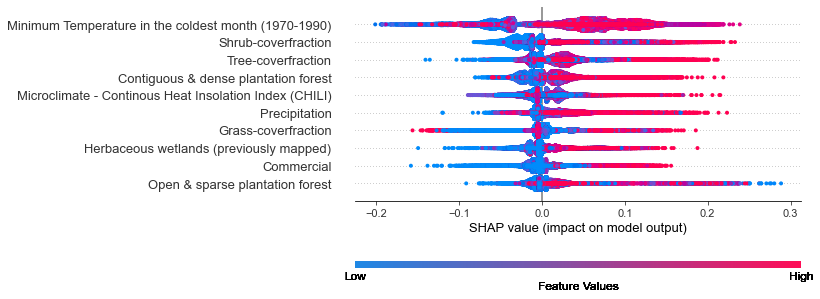

In [284]:
for province in tqdm(merge.NAME_1.unique()):
    flag = (merge.ADM1_EN==province).values
    shaps = shap_df[flag]
    feats = test.loc[flag, ~test.columns.str.startswith(('shap', 'label', 'pxid', 'NAME_1'))]

    shap.summary_plot(shaps.values, feats , feature_names = feature_names, max_display = 10, show=False, color_bar=False)
    cb=plt.colorbar()
    cb.remove()
    colors = ["#1E88E5", "#ff0d57"]
    cmap = LinearSegmentedColormap.from_list("mycmap", colors)

    m = plt.cm.ScalarMappable(cmap = cmap)
    m.set_clim(0., 1.)
    cb = plt.colorbar(m,orientation = 'horizontal', label= 'Feature values', ticks=[0, 1], format= '%.0f', aspect= 60, pad=0.2 )
    cb.set_ticklabels(['Low', 'High'])
    cb.set_label('Feature Values',size=12, labelpad=0)
    cb.ax.tick_params(labelsize=12, length=0)
    cb.set_alpha(1)
    cb.outline.set_visible(False)
    plt.savefig(f"D:/phd/Chapter_2/nat_drivers/4results/figures2/{str(province)}_shap_summary.png", dpi=600, transparent=True, bbox_inches='tight')

## Spatial distribution of variable importance

In [50]:
# Create plot
import ee
import geemap
import pandas as pd
import geopandas as gpd
from geemap import cartoee
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import matplotlib.cbook as cbook
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from matplotlib_scalebar.scalebar import ScaleBar
import great_circle_calculator.great_circle_calculator as gcc
import contextily as ctx
ee.Initialize()

In [53]:
# Group by id
var = df.groupby(["shap_minT", "minT"])["pxid"].mean().reset_index()

In [54]:
grid = grid[['geometry', 'label']]
grid.columns = ['geometry', 'pxid']
merge = gpd.GeoDataFrame(pd.merge(var, grid, on=["pxid"]), crs={'init': 'epsg:4326'})

You are merging on int and float columns where the float values are not equal to their int representation.
'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.


In [13]:
# # Link to shapefile
# eegrid = ee.FeatureCollection('users/geethensingh/SA_Grid_1dgr')
# grid = geemap.ee_to_geopandas(eegrid, selectors=['fid'])
# merge = gpd.GeoDataFrame(pd.merge(var, grid, on=["fid"]), crs={'init': 'epsg:4326'})

In [55]:
import os
import cartopy.crs as ccrs
import cartopy as ctpy
from math import floor
import matplotlib.pyplot as plt
from matplotlib import patheffects
import matplotlib
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
if os.name == 'nt':
    matplotlib.rc('font', family='Arial')
else:  # might need tweaking, must support black triangle for N arrow
    matplotlib.rc('font', family='DejaVu Sans')


def utm_from_lon(lon):
    """
    utm_from_lon - UTM zone for a longitude

    Not right for some polar regions (Norway, Svalbard, Antartica)

    :param float lon: longitude
    :return: UTM zone number
    :rtype: int
    """
    return floor( ( lon + 180 ) / 6) + 1

def scale_bar(ax, proj, length, location=(0.5, 0.05), linewidth=3,
              units='km', m_per_unit=1000):
    """

    http://stackoverflow.com/a/35705477/1072212
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    units is the name of the unit
    m_per_unit is the number of meters in a unit
    """
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    # Projection in metres
    utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * m_per_unit/2, sbcx + length * m_per_unit/2]
    # buffer for scalebar
    buffer = [patheffects.withStroke(linewidth=5, foreground="w")]
    # Plot the scalebar with buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, path_effects=buffer)
    # buffer for text
    buffer = [patheffects.withStroke(linewidth=3, foreground="w")]
    # Plot the scalebar label
    t0 = ax.text(sbcx, sbcy, str(length) + ' ' + units, transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2, fontsize= 16)
    left = x0+(x1-x0)*0.05
    # Add north arrow
    x, y, arrow_length = 0.05, 0.95, 0.1
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)
#     # Plot the N arrow
#     t1 = ax.text(left, sbcy, u'\u25B2\nN', transform=utm,
#         horizontalalignment='right', verticalalignment='bottom',
#         path_effects=buffer, zorder=2, fontsize= 18)
#     # Plot the scalebar without buffer, in case covered by text buffer
#     ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
#         linewidth=linewidth, zorder=3)

In [56]:
merge.columns

Index(['shap_minT', 'minT', 'pxid', 'geometry'], dtype='object')

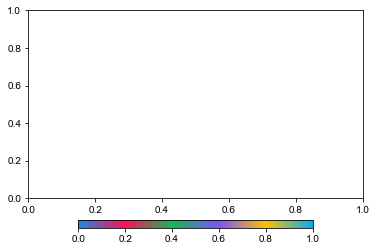

In [57]:
colors = ["#1E88E5", "#ff0d57", "#13B755", "#7C52FF", "#FFC000", "#00AEEF"] # 
cmap = LinearSegmentedColormap.from_list("mycmap", colors)
    # Create colorbar legend
sm = plt.cm.ScalarMappable(cmap= cmap, norm=plt.Normalize(vmin=0, vmax=1))
    # empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
    # add the colorbar to the figure
plt.colorbar(sm, orientation = "horizontal", fraction=0.036, pad=0.1, aspect = 30)
plt.show()

In [79]:
merge.columns

Index(['shap_minT', 'minT', 'pxid', 'geometry'], dtype='object')

Approximating coordinate system <Geographic 2D CRS: GEOGCRS["unknown",DATUM["Unknown based on WGS84 el ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: Unknown based on WGS84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.


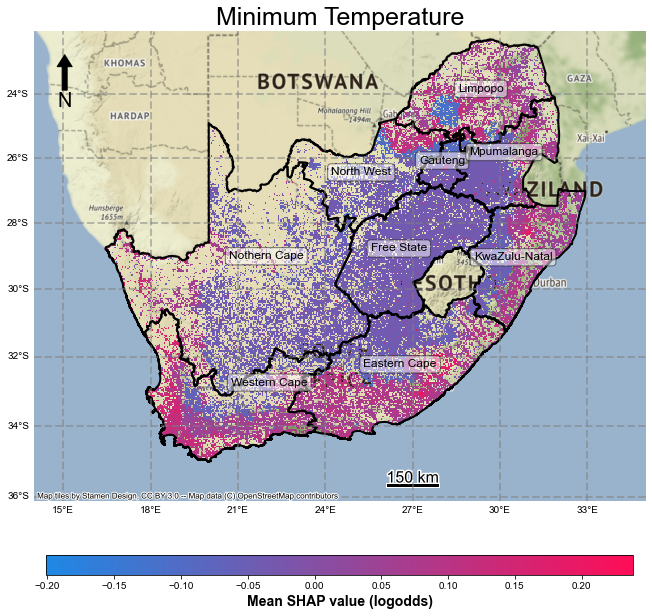

In [80]:
if __name__ == '__main__':
    
    #Set the Map Title
    title = 'Minimum Temperature'
    #Set the Colour bar title
    cb_label = 'Degrees Celsius (°C)'
    colors = ["#FFC000", "#00AEEF"]
    
    cb_label = 'Mean SHAP value (logodds)'
    colors = ["#1E88E5", "#ff0d57"]

    # set the value column that will be visualised
    variable = 'shap_minT'
    #uncomment if plotting shap vales
    # set the range for the choropleth values
    vmin, vmax = merge[variable].min(), merge[variable].max()
    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(30, 10), subplot_kw={"projection": ccrs.Mercator()})
    # ax = plt.axes(projection=ccrs.Mercator())
    # remove the axis
    ax.axis('off')
    # add a title and annotation
    ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})
    # ax.annotate('Source: Wikipedia - https://en.wikipedia.org/wiki/Provinces_of_Indonesia', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')
    
    cmap = LinearSegmentedColormap.from_list("mycmap", colors)
    # Create colorbar legend
    sm = plt.cm.ScalarMappable(cmap= cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # empty array for the data range
    sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
    # add the colorbar to the figure
    fig.colorbar(sm, orientation = "horizontal", fraction=0.036, pad=0.1, aspect = 30)\
    .set_label(label= cb_label,size=14,weight='bold')
    
    #plot data
    #Add coastal boundaries/backdrop
    #ax.stock_img()
    #ax.coastlines(resolution='10m')
    # before plotting convert to common crs
    merge = merge.to_crs('EPSG:3857')
    # plot grid data
    merge.plot(column=variable, cmap= cmap, linewidth=0, ax=ax, edgecolor='0.8', alpha=1)
    provinces = gpd.read_file(r"D:\Miscellenous\Data\SA_boundaries\zaf_admbnda_adm1_sadb_ocha_20201109.shp", crs=4326)
    provinces= provinces.to_crs(3857)
    
    # add province name annotations
    provinces['label_position'] = provinces['geometry'].apply(lambda x: x.representative_point().coords[:])
    provinces['label_position'] = [coords[0] for coords in provinces['label_position']]
    for idx, row in provinces.iterrows():
        plt.annotate(text=row['ADM1_EN'], xy=row['label_position'], horizontalalignment='center', fontsize=12,\
                     alpha =1.0, bbox=dict(boxstyle="round", fc="w", alpha= 0.5))
    provinces.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 2,ax=ax)
    ax.set_extent([14, 35, -36, -22], ccrs.Geodetic())
    
    # add scale bar
    scale_bar(ax, ccrs.Mercator(), 150, location = (0.5, 00.05))  # 150 km scale bar
    # or to use m instead of km
    # scale_bar(ax, ccrs.Mercator(), 100000, m_per_unit=1, units='m')
    # or to use miles instead of km
    # scale_bar(ax, ccrs.Mercator(), 60, m_per_unit=1609.34, units='miles')
    
    # add basemap
    ctx.add_basemap(ax)
    
    # add gridlines and coords
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    plt.savefig(f"D:/phd/Chapter_2/nat_drivers/4results/figures3/{'map_' + str(variable) + '.png'}", dpi=600, transparent=True, bbox_inches='tight')
    plt.show()

### Main driver per block

In [103]:
#format data with shap columns
for i in range(0, len(list(X_test))):
    ft_name =  str(list(X_test)[i])
    df= df.loc[test_set]
    df['shap_' + ft_name]= shap_values[:, i, 1]
#     sns.scatterplot(df[ft_name], (df['shap_' +ft_name]))

In [106]:
# Group by block id
group_by_block= df.groupby('pxid', as_index=False).mean()
group_by_block

pxid       CHILI  Global_Human_Modification        SPI  \
0          20.0  226.742511                   0.351560   0.334462   
1          21.0  217.773645                   0.030493   0.012985   
2          37.0  211.995434                   0.235330  17.517194   
3          92.0  227.166917                   0.310641   0.007048   
4          93.0  226.599365                   0.633486   0.003411   
...         ...         ...                        ...        ...   
35787  999847.0  223.000000                   0.023753   0.005281   
35788  999919.0  217.000000                   0.052713   0.823486   
35789  999936.0  217.568550                   0.049031   0.004711   
35790  999956.0  227.176491                   0.553739   0.669958   
35791  999996.0  220.825594                   0.210429   1.069345   

       bare-coverfraction  cation_ex_capacity  clay_content  commercial  \
0                1.511658           24.275878     26.787254    0.000000   
1               50.107803           24.374909     19.881136    0.000000   
2                0.737257           22.744180     29.996477    0.000000   
3                1.242219           21.317725     23.188492    0.123787   
4                0.352241           19.200763     20.091776    0.000000   
...                   ...                 ...           ...         ...   
35787           40.921459           18.825872     13.890894    0.000000   
35788           45.245634           24.969138     20.104721    0.000000   
35789           28.004966           20.187340     18.068115    0.000000   
35790            0.630751           21.479103     21.670609    0.000000   
35791            0.748773           23.482042     32.509732    0.000000   

       commercial annual crops rain-fed / dryland  \
0                                        0.000000   
1                                        0.000000   
2                                        0.049221   
3                                        1.187925   
4                                        0.000000   
...                                           ...   
35787                                    0.000000   
35788                                    0.000000   
35789                                    0.000000   
35790                                    0.000000   
35791                                    0.000000   

       contiguous & dense plantation forest  ...  \
0                                  0.546699  ...   
1                                  0.121782  ...   
2                                 24.365753  ...   
3                                  7.389897  ...   
4                                  0.292132  ...   
...                                     ...  ...   
35787                              0.409890  ...   
35788                              0.087744  ...   
35789                              0.234175  ...   
35790                              0.321049  ...   
35791                             32.999944  ...   

       shap_smallholdings (low veg / grass)  shap_residential informal (bush)  \
0                             -1.614139e-06                      2.949911e-05   
1                             -1.126001e-06                     -5.915514e-06   
2                             -1.050195e-04                     -1.742514e-04   
3                              2.723759e-04                      1.088636e-05   
4                             -9.667821e-07                     -2.981912e-06   
...                                     ...                               ...   
35787                         -1.422023e-05                     -4.556417e-06   
35788                         -2.046356e-06                     -1.141933e-06   
35789                         -1.470254e-04                     -1.869938e-04   
35790                         -9.931415e-07                     -4.584690e-07   
35791                         -3.975055e-05                     -1.732066e-04   

       shap_open woodland  \
0               -

In [107]:
# Select shap value columns
shap = group_by_block.loc[:, group_by_block.columns.str.startswith('shap')]
# Take Absolute values
# shapabs = shap.abs()

In [108]:
shap

shap_CHILI  shap_Global_Human_Modification  shap_SPI  \
0       -0.005640                       -0.000862 -0.000259   
1       -0.005574                       -0.001284 -0.000456   
2       -0.003635                       -0.001326 -0.008043   
3       -0.002866                        0.005680 -0.018258   
4       -0.006914                        0.001024 -0.000766   
...           ...                             ...       ...   
35787   -0.006976                       -0.000691 -0.001225   
35788   -0.005865                       -0.000605 -0.000385   
35789    0.004287                       -0.010184 -0.016292   
35790   -0.005101                        0.000231 -0.000366   
35791   -0.003749                       -0.001789 -0.006653   

       shap_bare-coverfraction  shap_cation_ex_capacity  shap_clay_content  \
0                     0.000682                -0.000019          -0.000323   
1                     0.000004                -0.001466          -0.000303   
2                     0.001122                -0.003340          -0.005626   
3                    -0.001185                -0.006687          -0.002889   
4                    -0.000293                 0.010775           0.000090   
...                        ...                      ...                ...   
35787                 0.000340                 0.011161           0.001006   
35788                -0.000181                -0.001310          -0.000059   
35789                 0.000060                 0.004413           0.002989   
35790                 0.000159                -0.001245          -0.000094   
35791                 0.008528                 0.001547          -0.008205   

       shap_commercial  shap_commercial annual crops rain-fed / dryland  \
0            -0.003222                                         0.000012   
1            -0.003714                                         0.000033   
2            -0.007547                                        -0.004081   
3             0.011597                                        -0.021110   
4            -0.003038                                         0.000053   
...                ...                                              ...   
35787        -0.003560                                         0.000013   
35788        -0.003674                                         0.000032   
35789        -0.004918                                        -0.000003   
35790        -0.003346                                         0.000059   
35791        -0.007074                                         0.004766   

       shap_contiguous & dense plantation forest  \
0                                      -0.007324   
1                                      -0.006356   
2                                       0.023843   
3                                      -0.001081   
4                                      -0.006030   
...                                          ...   
35787                                  -0.007245   
35788                                  -0.006414   
35789                                   0.002505   
35790                                  -0.005785   
35791                                   0.032502   

       shap_contiguous (indigenous) forest  ...  \
0                                 0.000470  ...   
1                                 0.002072  ...   
2                                 0.002193  ...   
3                                -0.000389  ...   
4                                -0.002324  ...   
...                                    ...  ...   
35787                            -0.003340  ...   
35788                            -0.001340  ...   
35789                            -0.023031  ...   
35790                            -0.001079  ...   
35791                             0.001577  ...   

       shap_smallholdings (low veg / grass)  shap_residential informal (bush)  \
0                             -1.614139e-06                      2.949911e-05   
1           

In [109]:
group_by_block['max_name'] = shap.idxmax(axis=1)

In [110]:
# Get column name with max value
group_by_block['max_no'] = shap.apply(np.argmax, axis=1)

In [111]:
group_by_block

pxid       CHILI  Global_Human_Modification        SPI  \
0          20.0  226.742511                   0.351560   0.334462   
1          21.0  217.773645                   0.030493   0.012985   
2          37.0  211.995434                   0.235330  17.517194   
3          92.0  227.166917                   0.310641   0.007048   
4          93.0  226.599365                   0.633486   0.003411   
...         ...         ...                        ...        ...   
35787  999847.0  223.000000                   0.023753   0.005281   
35788  999919.0  217.000000                   0.052713   0.823486   
35789  999936.0  217.568550                   0.049031   0.004711   
35790  999956.0  227.176491                   0.553739   0.669958   
35791  999996.0  220.825594                   0.210429   1.069345   

       bare-coverfraction  cation_ex_capacity  clay_content  commercial  \
0                1.511658           24.275878     26.787254    0.000000   
1               50.107803           24.374909     19.881136    0.000000   
2                0.737257           22.744180     29.996477    0.000000   
3                1.242219           21.317725     23.188492    0.123787   
4                0.352241           19.200763     20.091776    0.000000   
...                   ...                 ...           ...         ...   
35787           40.921459           18.825872     13.890894    0.000000   
35788           45.245634           24.969138     20.104721    0.000000   
35789           28.004966           20.187340     18.068115    0.000000   
35790            0.630751           21.479103     21.670609    0.000000   
35791            0.748773           23.482042     32.509732    0.000000   

       commercial annual crops rain-fed / dryland  \
0                                        0.000000   
1                                        0.000000   
2                                        0.049221   
3                                        1.187925   
4                                        0.000000   
...                                           ...   
35787                                    0.000000   
35788                                    0.000000   
35789                                    0.000000   
35790                                    0.000000   
35791                                    0.000000   

       contiguous & dense plantation forest  ...  shap_open woodland  \
0                                  0.546699  ...           -0.000046   
1                                  0.121782  ...           -0.000012   
2                                 24.365753  ...           -0.000697   
3                                  7.389897  ...           -0.000007   
4                                  0.292132  ...           -0.000013   
...                                     ...  ...                 ...   
35787                              0.409890  ...           -0.000011   
35788                              0.087744  ...           -0.000010   
35789                              0.234175  ...           -0.000090   
35790                              0.321049  ...           -0.000011   
35791                             32.999944  ...           -0.001066   

       shap_cultivated commercial sugarcane pivot irrigated  \
0                                              -0.000017      
1                                              -0.000010      
2                                              -0.000128      
3                                               0.000046      
4                                              -0.000014      
...                                                  ...      
35787                                          -0.000011      
35788                                          -0.000009      
35789                                          -0.000017      
35790                                          -0.000012      
35791                                          -0.000467      

       shap_coastal sa

In [112]:
# Join to grid
# eegrid = ee.FeatureCollection('users/geethensingh/SA_Grid_1dgr')
# grid = geemap.ee_to_geopandas(eegrid, selectors=['fid'])
merge = gpd.GeoDataFrame(pd.merge(group_by_block, grid, on=["pxid"]), crs={'init': 'epsg:4326'})

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.


In [113]:
import os
import cartopy.crs as ccrs
import cartopy as ctpy
from math import floor
import matplotlib.pyplot as plt
from matplotlib import patheffects
import matplotlib
import contextily as ctx
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

new_tab = cm.get_cmap('tab20', 17)

if os.name == 'nt':
    matplotlib.rc('font', family='Arial')
else:  # might need tweaking, must support black triangle for N arrow
    matplotlib.rc('font', family='DejaVu Sans')


def utm_from_lon(lon):
    """
    utm_from_lon - UTM zone for a longitude

    Not right for some polar regions (Norway, Svalbard, Antartica)

    :param float lon: longitude
    :return: UTM zone number
    :rtype: int
    """
    return floor( ( lon + 180 ) / 6) + 1

def scale_bar(ax, proj, length, location=(0.5, 0.05), linewidth=3,
              units='km', m_per_unit=1000):
    """

    http://stackoverflow.com/a/35705477/1072212
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    units is the name of the unit
    m_per_unit is the number of meters in a unit
    """
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    # Projection in metres
    utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * m_per_unit/2, sbcx + length * m_per_unit/2]
    # buffer for scalebar
    buffer = [patheffects.withStroke(linewidth=5, foreground="w")]
    # Plot the scalebar with buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, path_effects=buffer)
    # buffer for text
    buffer = [patheffects.withStroke(linewidth=3, foreground="w")]
    # Plot the scalebar label
    t0 = ax.text(sbcx, sbcy, str(length) + ' ' + units, transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2, fontsize= 16)
    left = x0+(x1-x0)*0.05
    # Add north arrow
    x, y, arrow_length = 0.05, 0.95, 0.1
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)
#     # Plot the N arrow
#     t1 = ax.text(left, sbcy, u'\u25B2\nN', transform=utm,
#         horizontalalignment='right', verticalalignment='bottom',
#         path_effects=buffer, zorder=2, fontsize= 18)
#     # Plot the scalebar without buffer, in case covered by text buffer
#     ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
#         linewidth=linewidth, zorder=3)

In [114]:
merge['max_name'] = merge['max_name'].str.replace('shap_', '')

In [230]:
regroup = {
'Hydrological': ['dsrcnt', 'wSeasonality', 'water-permanent-coverfraction','SPI','water-seasonal-coverfraction',\
                  'flood','runoff'],
'Natural land cover': ['grass-coverfraction','shrub-coverfraction', 'contiguous low forest & thicket',\
                       'low shrubland (other)','herbaceous wetlands (previously mapped)',\
                       'low shrubland (succulent karoo)','tree-coverfraction', 'mangrove wetlands',\
                       'sand dunes (terrestrial)','dense forest & woodland',
                       'contiguous (indigenous) forest','sparsely wooded grassland','low shrubland (fynbos)',\
                       'natural ocean & coastal','low shrubland (nama karoo)', 'coastal sand & dunes',\
                       'natural pans (flooded @ observation times)','natural rock surfaces','bare-coverfraction',\
                      'natural lakes','open woodland','natural rivers','urban recreational fields (bush)',\
                       'fallow land & old fields (trees)','natural grassland'],
'Climatic': ['minT','precipitation','wind_speed','CHILI','topD'],
'Ecological': ['aq_veg_area','cation_ex_capacity','soc_100-200cm_mean','clay_content','fcc','stone_content',\
                  'sand_content','nitrogen_total'],
'Socio-economic': ['temporary unplanted (clear-felled) plantation forest',\
                                  'contiguous & dense plantation forest','open & sparse plantation forest',
                                  'roads & rails (major linear)','industrial','commercial',\
                                'mines: extraction pits, quarries',\
                                  'artificial flooded mine pits','artificial sewage ponds',\
                                 'Global_Human_Modification','distance_to_roads', 'artificial dams (including canals)',\
                                'residential formal (bare)','urban-coverfraction','mine: tailings and resource dumps',\
                                 'land-fills','residential informal (tree)','mines: salt mines',\
                                'village scattered (bare & low veg/ grss combo)','smallholdings (low veg / grass)',\
                                 'residential informal (bush)','commercial annual crops rain-fed / dryland',\
                        'cultivated commercial permanent vines','crops-coverfraction','cultivated commercial permanent orchards',\
                'cultivated commercial sugarcane non-pivot','fallow land & old fields (bush)',\
                'subsistence / small-scale annual crops','natural estuaries & lagoons',\
                'cultivated commercial sugarcane pivot irrigated','commercial annual crops pivot irrigated',\
                'cultivated commercial permanent pineapples']                 
    }

In [231]:
merge['regroup_name']=0
for key in list(regroup.keys()):
    merge.loc[merge['max_name'].isin(regroup[key]), ('regroup_name')]=key

In [232]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
merge[['regroup_name', 'max_name']].value_counts()

regroup_name        max_name                                            
Climatic            minT                                                    10850
Natural land cover  shrub-coverfraction                                      3333
                    grass-coverfraction                                      3286
Climatic            CHILI                                                    2574
Socio-economic      temporary unplanted (clear-felled) plantation forest     2474
Hydrological        wSeasonality                                             2048
Climatic            precipitation                                            1555
Natural land cover  tree-coverfraction                                       1276
                    herbaceous wetlands (previously mapped)                   798
                    contiguous low forest & thicket                           745
Ecological          cation_ex_capacity                                        721
Socio-economic      open 

In [233]:
# Create color palette

# colors = ["blue", "#ff0d57", "#13B755", "#7C52FF", "#FFC000", "#00AEEF",'white', '#EF553B', 'white']
# cmap = ListedColormap(colors)
cmap = 'viridis'

Approximating coordinate system <Geographic 2D CRS: GEOGCRS["unknown",DATUM["Unknown based on WGS84 el ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: Unknown based on WGS84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.


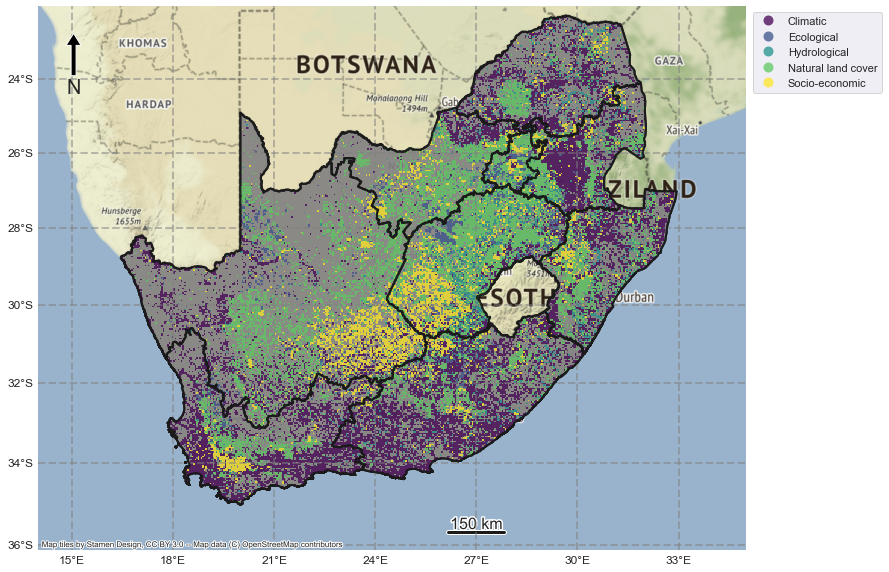

In [253]:
from matplotlib import ticker
from matplotlib.patches import Patch

if __name__ == '__main__':
    
    # set the value column that will be visualised
    variable = 'regroup_name'
    # set the range for the choropleth values
    vmin, vmax = merge[variable].min(), merge[variable].max()
    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(30, 10), subplot_kw={"projection": ccrs.Mercator()})
    # remove the axis
    ax.axis('off')

    provinces = gpd.read_file(r"D:\Miscellenous\Data\SA_boundaries\zaf_admbnda_adm1_sadb_ocha_20201109.shp", crs=4326)
    provinces= provinces.to_crs(3857)
    provinces.geometry.boundary.plot(color= None, edgecolor='k',linewidth = 2,ax=ax, facecolor='grey', alpha=0.9, zorder=1)
    ax.set_extent([14, 35, -36, -22], ccrs.Geodetic())#26, 35, -26, -22
    scale_bar(ax, ccrs.Mercator(), 150, location = (0.5, 00.05))  # 150 km scale bar
    
    merge = merge.to_crs('EPSG:3857')
    merge.plot(column=variable, cmap = cmap, linewidth=0, ax=ax,\
               alpha= 0.75, categorical= True,legend =True, edgecolor='k', facecolor = 'k', zorder=2)
    provinces.geometry.boundary.plot(color= None,edgecolor='k',linewidth = 2,ax=ax, alpha=0.9, zorder=3)
    # Adjust legend location
    # handles,_ = ax.get_legend_handles_labels() # get existing handles and labels
    # nodata = Patch(color='grey', label='No data')  # add new patches and labels to lis
    # ax.legend(handles = [*handles], loc= 'best')
    leg = ax.get_legend()
    leg.set_bbox_to_anchor((1.2,1))
    
    ctx.add_basemap(ax)
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    plt.savefig(r"D:\phd\Chapter_2\nat_drivers\4results\figures3\map_1_important_feature.png", dpi=600, transparent=True, bbox_inches='tight')
    plt.show()

FixedFormatter should only be used together with FixedLocator


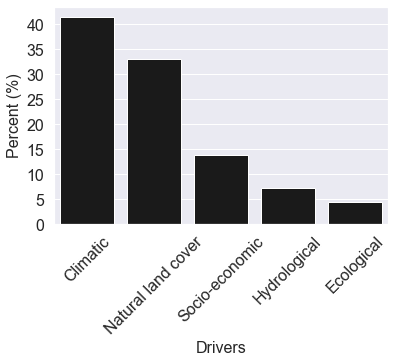

In [319]:
df = sns.load_dataset('titanic')
df.head()

# x = 'regroup_name'

df1 = pd.DataFrame(merge['regroup_name'].value_counts(normalize=True).mul(100)).reset_index()
df1.columns= ['Driver', 'percent']
df1

g = sns.barplot(x='Driver',y='percent',data=df1, orient= 'v', color = 'k')

g.set_xlabel('Drivers', size = 16)
_, xlabels = plt.xticks()
plt.setp(xlabels, rotation=45, size=16)
g.set_ylabel('Percent (%)', size = 16)
g.set_yticklabels(g.get_yticks().astype('int'), size = 16)
g.figure.savefig(r"D:\phd\Chapter_2\nat_drivers\4results\figures3\important_feature_count.png", dpi=600, transparent=True, bbox_inches='tight')


### Effect of data size on accuracy

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\G10\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\G10\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\_forest.py", line 304, in fit
    accept_sparse="csc", dtype=DTYPE)
  File "C:\Users\G10\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\G10\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py", line 72, in inner_f
    return f(**kwargs)
  File "C:\Users\G10\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py", line 802, in check_X_y
    estimator=estimator)
  File "C:\Users\G10\AppData\Roaming\Python\Python36\site-packages\sklearn

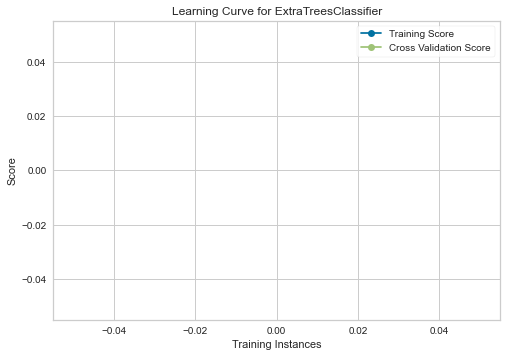

LearningCurve(ax=<AxesSubplot:title={'center':'Learning Curve for ExtraTreesClassifier'}, xlabel='Training Instances', ylabel='Score'>,
              cv=[(array([     2,      3,      4, ..., 248332, 248333, 248334]),
                   array([     0,      1,      8, ..., 246511, 246514, 246516])),
                  (array([     0,      1,      2, ..., 248331, 248332, 248333]),
                   array([   449,    638,   3318, ..., 247913, 248247, 248334])),
                  (array([     0,      1,      2, ..., 248331, 248333, 248334]),
                   array...
                   array([   205,    244,    249, ..., 233779, 233784, 233785])),
                  (array([     0,      1,      2, ..., 248332, 248333, 248334]),
                   array([    32,     38,     46, ..., 248219, 248256, 248266])),
                  (array([     0,      1,      5, ..., 248332, 248333, 248334]),
                   array([     2,      3,      4, ..., 248321, 248322, 248331])),
                  (ar

In [31]:
from yellowbrick.model_selection import learning_curve
from sklearn import model_selection,ensemble
from sklearn.metrics import make_scorer
from sklearn import metrics
# 'balanced_accuracy': make_scorer(metrics.balanced_accuracy_score),
# 'precision': make_scorer(metrics.precision_score, average='macro'),
#                  'recall': make_scorer(metrics.recall_score, average='macro'),
#                  'f1': make_scorer(metrics.),matthews_corrcoef


# rfc = ensemble.ExtraTreesClassifier()
print(learning_curve(rfc, X, y, cv= block_cv, scoring= make_scorer(metrics.f1_score, average='macro'), n_jobs=-1))

# plt.savefig(r"D:\phd\Chapter_3\nat_drivers\4results\figures\learning_curve_f1.png", dpi=600, transparent=True, bbox_inches='tight')
# plt.show()